# Node2vec model
This is extension of IIITD.ipynb file, so I will not add preprocessing steps. I will directly use the preprocessed dataset which is stored in main.txt

In [28]:
import pickle
import pandas as pd
import numpy as np
import os
import random

import networkx as nx

import stellargraph as sg
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import DirectedGraphSAGENodeGenerator
from stellargraph.layer import DirectedGraphSAGE
from gensim.models import Word2Vec

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
import matplotlib.pyplot as plt
%matplotlib inline

Loading dataset from main.txt and citation graph

In [29]:
MAIN = {}
with open('./main.txt', 'rb') as outfile:
    MAIN = pickle.load(outfile)

In [30]:
CITATIONS = "./Dataset/hep-th-citations"
citationGraph = pd.read_table(CITATIONS)
citationGraph.columns = [' ']
citationGraph = citationGraph.to_numpy()
citationGraphX, citationGraphY = [x[0].split(' ')[1] for x in citationGraph], [x[0].split(' ')[0] for x in citationGraph]

In [31]:
unique_X, unique_Y = list(set(citationGraphX)), list(set(citationGraphY))

In [74]:
X_train_ids = unique_X[:200]
X, Y = [], []
for x in X_train_ids:
    idxs = [i for i, val in enumerate(citationGraphY) if val == x ] # All matching index with id=x
    for i in idxs:
        X.append(MAIN[citationGraphX[i]]['AUTHORS'])
        Y.append(MAIN[x]['AUTHORS'])

In [75]:
for index, row in enumerate(X):
    X[index] = [i for i in row if i != '' and len(i) > 2]

for index, row in enumerate(Y):
    Y[index] = [i for i in row if i != '' and len(i) > 2]

## Directed graphs
Creating dreicted weighted graphs were each edge has weights according to the frequence of co-occurrence. 

In [76]:
# Make DataFrame which will contain two columns
# First column will have Research paper's authors
# Second column will have citation paper's authors

def getDiGraph(X, Y):
    """
        X = [List of ...[...List of citation paper...]...]
        Y = [List of ...[...List of research paper...]...]
    """
    nodes, edges = [], []
    frequences = {} # weights are frequence of the target-source in the graph
    for index, xrow in enumerate(X):
        nodes.extend(xrow)
        nodes.extend(Y[index])

        for x in xrow:
            for y in Y[index]:
                if (x, y) not in frequences.keys():
                    frequences[(x, y)] = 0
                frequences[(x, y)] = frequences[(x, y)] + 1
                edges.append((x, y, frequences[(x, y)]))
    
    nodes = list(set(nodes))
    AUTH_MAP = {y:x for x,y in enumerate(nodes)}

    G = nx.DiGraph()
    for i in nodes:
        G.add_node(i)
    

    G.add_weighted_edges_from(edges)

    return sg.StellarGraph.from_networkx(G), G, AUTH_MAP

diGraph, nxGraph, AUTH_MAP = getDiGraph(Y, X)

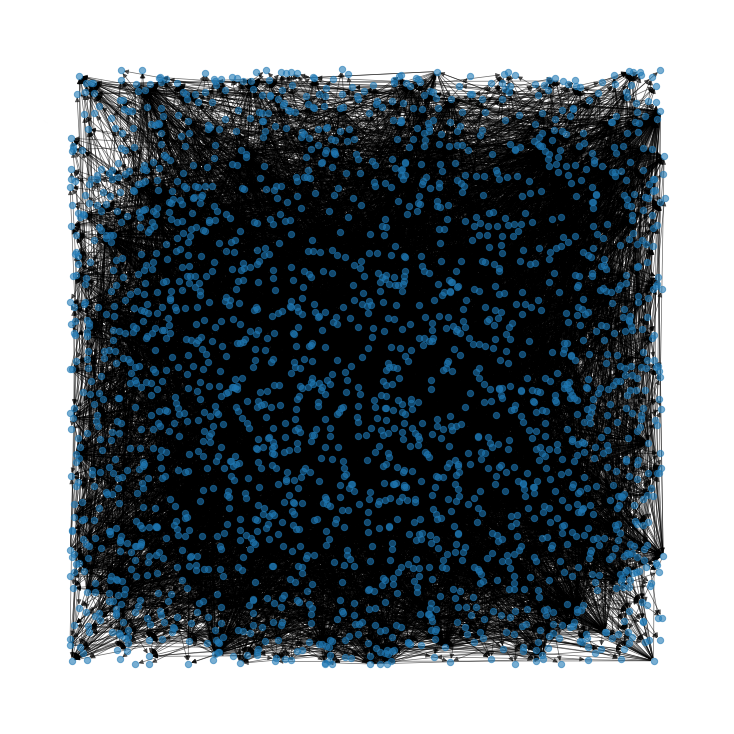

In [8]:
import networkx as nx

# Draw the graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(nxGraph, seed=23)
nx.draw(nxGraph, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [77]:
print(diGraph.info())

StellarDiGraph: Directed multigraph
 Nodes: 2248, Edges: 10405

 Node types:
  default: [2248]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [10405]
        Weights: range=[1, 15], mean=1.4297, std=1.01279
        Features: none


## Extract features from the graph
Extract features and then create an word2vec model where inputs are the feature extracted using randomwalks on the directed graphs

In [78]:
rw = BiasedRandomWalk(diGraph)

walk_length = 100

weighted_walks = rw.run(
    nodes=diGraph.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

weighted_model = Word2Vec(
    weighted_walks, size=128, window=20, min_count=0, sg=1, workers=1, iter=5
)

Number of random walks: 22480


In [79]:
weighted_model.wv['p.s. howe'].shape

(128,)

In [80]:
node_ids = weighted_model.wv.index2word
word2id = {y:x for x, y in enumerate(node_ids)}

# Adding 'PAD' to the list
embedding_matrix = weighted_model.wv.vectors
PAD_vector = np.zeros(128)
PAD_index = 0 # PAD tokens are indexed as 0
embedding_matrix = np.insert(embedding_matrix, [PAD_index], PAD_vector, axis=0)
word2id = {word: (index + 1) if index >= PAD_index else index for word, index in word2id.items()}
word2id['PAD'] = PAD_index

In [81]:
node_ids = {y: x for x, y in word2id.items()}

## Neural network
Making a simile NN using keras.

In [82]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Embedding

In [83]:
vocab_length = len(embedding_matrix) + 1
EMB_DIM = 128
# create a weight matrix for words
embedding_matrix = np.zeros((vocab_length, EMB_DIM))
for word, i in word2id.items():
    try:
        embedding_matrix[i] = weighted_model.wv.vectors[i]
    except:
        continue

In [84]:
from sklearn.metrics import accuracy_score
from keras import backend as K
import tensorflow_addons as tfa

embedding_layer = Embedding(
    input_dim=vocab_length,
    output_dim=EMB_DIM,
    weights=[embedding_matrix],
    input_length=4
)

def getModel(labels):
    citation = layers.Input((4, ))
    inp1 = embedding_layer(citation)
    inp1 = layers.Flatten()(inp1)
    dense1 = layers.Dense(64, activation="relu")(inp1)
    dense2 = layers.Dense(512, activation="relu")(dense1)
    output = layers.Dense(labels, activation="sigmoid")(dense2)
    model = keras.Model(inputs=citation, outputs=output)
    model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), optimizer='adam', metrics=[tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
    return model

model = getModel(vocab_length)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 4, 128)            288000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               33280     
_________________________________________________________________
dense_8 (Dense)              (None, 2250)              1154250   
Total params: 1,508,362
Trainable params: 1,508,362
Non-trainable params: 0
_________________________________________________

In [85]:
from keras.preprocessing.sequence import pad_sequences

for index, row in enumerate(X):
    X[index] = [word2id[i] for i in row]

max_length = 4
X = pad_sequences(X, maxlen=max_length, padding='post')

for index, row in enumerate(Y):
    Y[index] = [word2id[i] for i in row]

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y)

print(f'Training size: {len(X_train)}\nTest size: {len(X_test)}')

Training size: 2278
Test size: 760


In [88]:
def yEncoding(y, labels):
    ret_y = np.zeros((len(y), labels))
    for index, row in enumerate(y):
      for i in row:
          if i != 0.0:
            ret_y[index][int(i)] = 1
    
    return ret_y

y_train = yEncoding(y_train, vocab_length)

In [89]:
X_train = np.asarray([np.asarray(i, dtype=np.float32) for i in X_train], dtype=np.float32)
X_test = np.asarray([np.asarray(i, dtype=np.float32) for i in X_test], dtype=np.float32)
y_train = np.asarray([np.asarray(i, dtype=np.float32) for i in y_train], dtype=np.float32)

In [90]:
training = model.fit(X_train, y_train, batch_size=16, epochs=25, shuffle=True)

Epoch 1/25
143/143 [==============================] - 2s 11ms/step - loss: 37.8277 - precision: 0.0012 - recall: 0.0044 - auc: 0.6462
Epoch 2/25
143/143 [==============================] - 2s 11ms/step - loss: 1.3620 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9439
Epoch 3/25
143/143 [==============================] - 2s 11ms/step - loss: 1.2401 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9574
Epoch 4/25
143/143 [==============================] - 2s 11ms/step - loss: 1.2019 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9630
Epoch 5/25
143/143 [==============================] - 2s 12ms/step - loss: 1.1674 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9676
Epoch 6/25
143/143 [==============================] - 2s 11ms/step - loss: 1.1295 - precision: 1.0000 - recall: 1.9972e-04 - auc: 0.9722
Epoch 7/25
143/143 [==============================] - 2s 11ms/step - loss: 1.0834 - precision: 0.8333 - recall: 0.0020 - auc: 0.9772
Epoch 8/25
143/143 [============

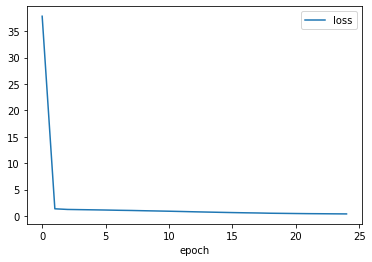

In [91]:
from matplotlib import pyplot as plt
plt.plot(training.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper right')
plt.show()

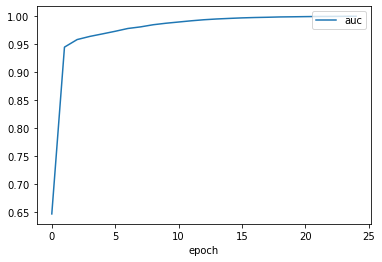

In [92]:
from matplotlib import pyplot as plt
plt.plot(training.history['auc'])
plt.xlabel('epoch')
plt.legend(['auc'], loc='upper right')
plt.show()

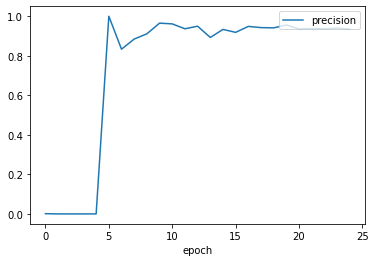

In [93]:
from matplotlib import pyplot as plt
plt.plot(training.history['precision'])
plt.xlabel('epoch')
plt.legend(['precision'], loc='upper right')
plt.show()

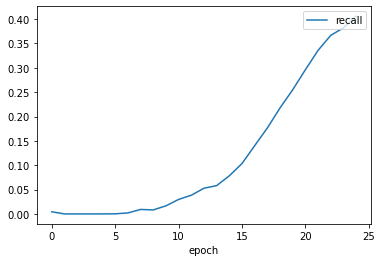

In [94]:
from matplotlib import pyplot as plt
plt.plot(training.history['recall'])
plt.xlabel('epoch')
plt.legend(['recall'], loc='upper right')
plt.show()

### Make predictions

In [117]:
index = random.randint(0, len(X_test))
pred = model.predict(np.asarray([X_test[index]]))
print(f'Input authors: {[node_ids[i] for i in X_test[index] if node_ids[i] != "PAD"]}')
for i in np.argsort(pred)[0]:
    if node_ids[i] != 'PAD':
        print(f'Predicted: {node_ids[i], pred[0][i]}')
        break
print(f'Real authors: {[node_ids[i] for i in y_test[index] if i != 0]}')

Input authors: ['a. zaffaroni', 'l. girardello', 'm. petrini', 'm. porrati']
Predicted: ('barton zwiebach', 8.871618e-08)
Real authors: ['kyungho oh', 'radu tatar']
